# 1. 실습환경 Set-up

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 필요한 변수
BATCH_SIZE = 16
EPOCHS = 25

# 2. 데이터 준비하기

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

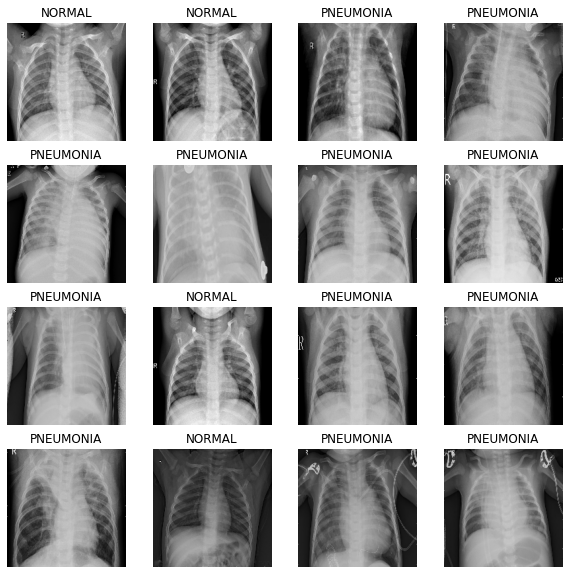

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 63s 192ms/step - loss: 0.4512 - accuracy: 0.7744 - precision: 0.9377 - recall: 0.7463 - val_loss: 0.7087 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2487 - accuracy: 0.9061 - precision: 0.9699 - recall: 0.9018 - val_loss: 1.4801 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1973 - accuracy: 0.9301 - precision: 0.9783 - recall: 0.9266 - val_loss: 0.1437 - val_accuracy: 0.9423 - val_precision: 0.9294 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1757 - accuracy: 0.9346 - precision: 0.9807 - recall: 0.9305 - val_loss: 0.4854 - val_accuracy: 0.8471 - val_precision: 0.9984 - val_recall: 0.7937
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1836 - accura

# 7. 결과 확인과 시각화

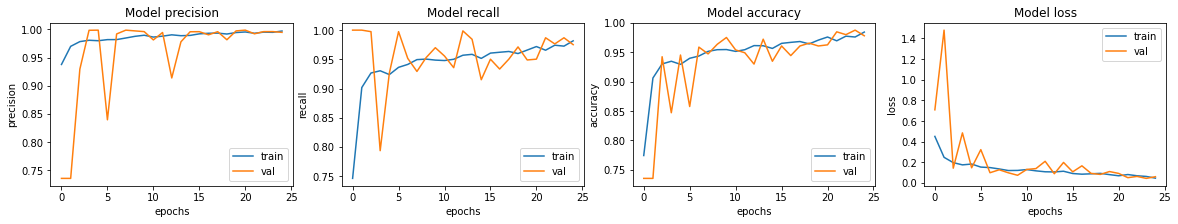

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 0.8171 - accuracy: 0.8478 - precision: 0.8067 - recall: 0.9949
Loss: 0.817067563533783,
Accuracy: 0.8477563858032227,
Precision: 0.8066527843475342,
Recall: 0.9948717951774597


# 8. Optimizer 변경하기

## (1) Adadelta

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='Adadelta',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 54s 181ms/step - loss: 0.5007 - accuracy: 0.7466 - precision: 0.9444 - recall: 0.7006 - val_loss: 0.3515 - val_accuracy: 0.8837 - val_precision: 0.9820 - val_recall: 0.8575
Epoch 2/25
261/261 [==============================] - 47s 179ms/step - loss: 0.5072 - accuracy: 0.7375 - precision: 0.9324 - recall: 0.6975 - val_loss: 0.3704 - val_accuracy: 0.8673 - val_precision: 0.9876 - val_recall: 0.8303
Epoch 3/25
261/261 [==============================] - 46s 178ms/step - loss: 0.4949 - accuracy: 0.7498 - precision: 0.9384 - recall: 0.7103 - val_loss: 0.3376 - val_accuracy: 0.8837 - val_precision: 0.9849 - val_recall: 0.8549
Epoch 4/25
261/261 [==============================] - 47s 181ms/step - loss: 0.4953 - accuracy: 0.7431 - precision: 0.9387 - recall: 0.7004 - val_loss: 0.3647 - val_accuracy: 0.8702 - val_precision: 0.9861 - val_recall: 0.8351
Epoch 5/25
261/261 [==============================] - 48s 183ms/step - loss: 0.4744 - accura

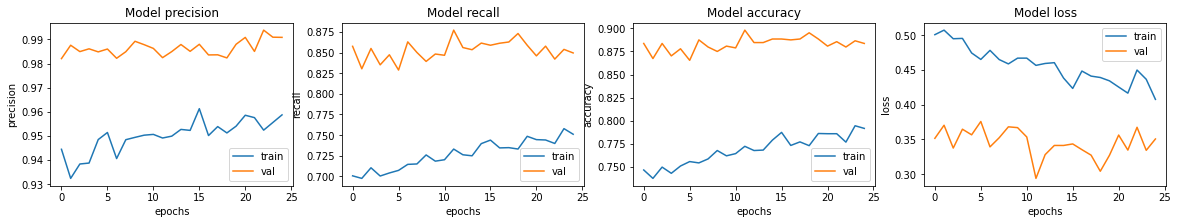

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 0.3721 - accuracy: 0.8510 - precision: 0.8981 - recall: 0.8590
Loss: 0.37206655740737915,
Accuracy: 0.8509615659713745,
Precision: 0.8981233239173889,
Recall: 0.8589743375778198


## (2) Adamax

In [30]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='Adamax',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 56s 181ms/step - loss: 0.4690 - accuracy: 0.7658 - precision: 0.9444 - recall: 0.7279 - val_loss: 0.5787 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 47s 181ms/step - loss: 0.2870 - accuracy: 0.8721 - precision: 0.9693 - recall: 0.8551 - val_loss: 0.7960 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 47s 181ms/step - loss: 0.2601 - accuracy: 0.8961 - precision: 0.9715 - recall: 0.8866 - val_loss: 0.3608 - val_accuracy: 0.8106 - val_precision: 0.7950 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 47s 179ms/step - loss: 0.2609 - accuracy: 0.9057 - precision: 0.9698 - recall: 0.9011 - val_loss: 0.1110 - val_accuracy: 0.9663 - val_precision: 0.9753 - val_recall: 0.9791
Epoch 5/25
261/261 [==============================] - 48s 185ms/step - loss: 0.2222 - accura

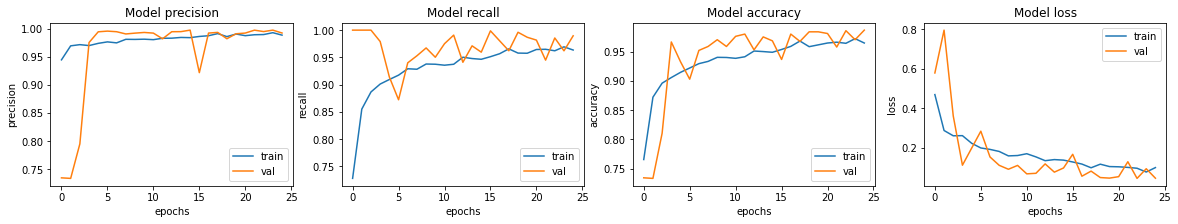

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 113ms/step - loss: 0.8323 - accuracy: 0.7580 - precision: 0.7217 - recall: 0.9974
Loss: 0.8323124647140503,
Accuracy: 0.7580128312110901,
Precision: 0.7217068672180176,
Recall: 0.9974358677864075


## (3) Adagrad

In [34]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='Adagrad',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [35]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 56s 185ms/step - loss: 0.6211 - accuracy: 0.6595 - precision: 0.8874 - recall: 0.6213 - val_loss: 0.6486 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 47s 182ms/step - loss: 0.4296 - accuracy: 0.7711 - precision: 0.9649 - recall: 0.7181 - val_loss: 0.5734 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 185ms/step - loss: 0.3914 - accuracy: 0.7950 - precision: 0.9707 - recall: 0.7470 - val_loss: 0.2450 - val_accuracy: 0.9567 - val_precision: 0.9615 - val_recall: 0.9804
Epoch 4/25
261/261 [==============================] - 48s 185ms/step - loss: 0.3618 - accuracy: 0.8245 - precision: 0.9729 - recall: 0.7858 - val_loss: 0.2926 - val_accuracy: 0.8875 - val_precision: 0.9894 - val_recall: 0.8560
Epoch 5/25
261/261 [==============================] - 48s 185ms/step - loss: 0.3248 - accura

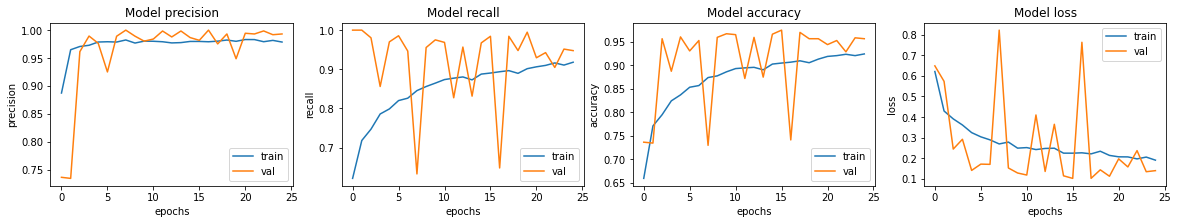

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 0.4186 - accuracy: 0.8173 - precision: 0.7851 - recall: 0.9744
Loss: 0.41859251260757446,
Accuracy: 0.817307710647583,
Precision: 0.7851239442825317,
Recall: 0.9743589758872986


# 9. 결과

**Adam**
Loss: 0.817067563533783,
Accuracy: 0.8477563858032227,
Precision: 0.8066527843475342,
Recall: 0.9948717951774597

**Adadelta**
Loss: 0.37206655740737915,
Accuracy: 0.8509615659713745,
Precision: 0.8981233239173889,
Recall: 0.8589743375778198

**Adamax**
Loss: 0.8323124647140503,
Accuracy: 0.7580128312110901,
Precision: 0.7217068672180176,
Recall: 0.9974358677864075

**Adagard**
Loss: 0.41859251260757446,
Accuracy: 0.817307710647583,
Precision: 0.7851239442825317,
Recall: 0.9743589758872986

**==> Adadelta가 accuracy 85%로 가장 높게 나왔다.**

# 10. 회고

퍼실님이 잠깐 언급하신 대로 이미지 사이즈 변경, 좌우반저 등 전처리를 할까 생각해보았는데, 크게 성능이 나아지지 않았다는 말을 듣고 어떻게 할까 고민을했다. 바꿀 수 있는 요소는 batch size, epoch, optimizer가 있었는데,batch size, epoch는 변경해도 크게 성능이 나아지질 않아 optimizer를 바꿔보았다. recall 값이 가장 높은 것은 adamax이긴 하였지만 accuracy가 너무 낮아 사용하는 것은 어려울 것 같다. adadelta의 경우 recall값은 가장 낮지만 accuracy가 가장 높게 나왔다. 왜 adadelta만 recall값이 85%대로 떨어진 것인지 정확히 이해하지는 못했다ㅜ 조금 더 검색해보고 공부해야겠다는 생각이 든다. 그래도 간당간당하지만 85%는 달성했다..! 의사분들은 90%라니 아직 갈길이 멀다는 걸 다시금 느낀다.